<a href="https://colab.research.google.com/github/sridevibonthu/EVA/blob/master/S10/Assignment10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries

In [1]:
!git clone https://github.com/sridevibonthu/EVALibrary.git
import sys
sys.path.append("/content/EVA4_LIBRARY/EVA4")

Cloning into 'EVALibrary'...
remote: Enumerating objects: 37, done.
remote: Counting objects: 100% (37/37), done.
remote: Compressing objects: 100% (29/29), done.
remote: Total 37 (delta 7), reused 37 (delta 7), pack-reused 0
Unpacking objects: 100% (37/37), done.


# Installation of Latest Albumentations Library

In [2]:
!pip install -U git+https://github.com/albu/albumentations > /dev/null && echo "All libraries are successfully installed!"

  Running command git clone -q https://github.com/albu/albumentations /tmp/pip-req-build-1sfqpyhg
All libraries are successfully installed!


In [3]:
from torchvision import datasets
train = datasets.CIFAR10('./data', train=True, download=True)

Files already downloaded and verified


In [4]:
from tqdm import tqdm_notebook
from PIL import Image
import numpy as np
n = 0
s = np.zeros(3)
sq = np.zeros(3)
for data, l in tqdm_notebook(train):
  x = np.array(data)/255
  s += x.sum(axis=(0,1))
  sq += np.sum(np.square(x), axis=(0,1))
  n += x.shape[0]*x.shape[1]

mu = s/n
std = np.sqrt((sq/n - np.square(mu)))
print(mu, sq/n, std, n)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  import sys



[0.49139968 0.48215841 0.44653091] [0.30249857 0.29176174 0.26781806] [0.24703223 0.24348513 0.26158784] 51200000


In [0]:
# add path to our library in default search path
import sys
sys.path.append('/content/drive/My Drive/EVA4')

## Data Transformations

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise. 


In [0]:
import numpy as np
from eva4datatransforms import AlbumentationTransforms
import albumentations as A

channel_means = (0.49139968, 0.48215841, 0.44653091)
channel_stdevs = (0.24703223, 0.24348513, 0.26158784)
# Train Phase transformations
train_transforms = AlbumentationTransforms([
                                       A.Rotate((-30.0, 30.0)),
                                       A.HorizontalFlip(),
                                       A.RGBShift(r_shift_limit=50, g_shift_limit=50, b_shift_limit=50, p=0.5),
                                       A.Normalize(mean=channel_means, std=channel_stdevs),
                                       A.Cutout(num_holes=4) # fillvalue is 0 after normalizing as mean is 0
                                       ])

fillmeans = (np.array(channel_means)).astype(np.uint8)



# Test Phase transformations
test_transforms = AlbumentationTransforms([A.Normalize(mean=channel_means, std=channel_stdevs)])



# Dataset and Creating Train/Test Split

In [7]:
from torchvision import datasets
train = datasets.CIFAR10('./data', train=True, download=True, transform=train_transforms)
test = datasets.CIFAR10('./data', train=False, download=True, transform=test_transforms)

Files already downloaded and verified
Files already downloaded and verified


# Dataloader Arguments & Test/Train Dataloaders


In [0]:
import eva4dataloaders

dataloader = eva4dataloaders.DataLoader(batch_size=128)

# train dataloader
train_loader = dataloader.load(train)

# test dataloader
test_loader = dataloader.load(test)

# Data Statistics

It is important to know your data very well. Let's check some of the statistics around our data and how it actually looks like

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([128, 3, 32, 32])
torch.Size([128])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


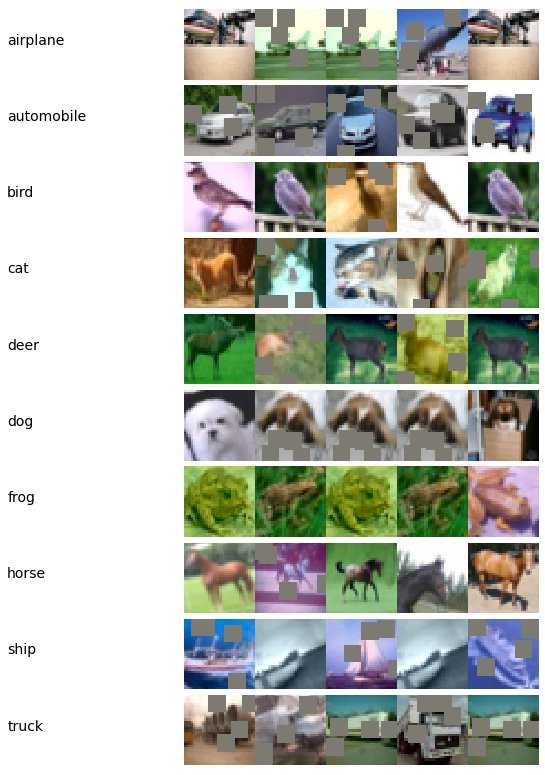

In [9]:
from __future__ import print_function
def unnormalize(img):
  img = img.cpu().numpy().astype(dtype=np.float32)
  
  for i in range(img.shape[0]):
    img[i] = (img[i]*channel_stdevs[i])+channel_means[i]
  
  return np.transpose(img, (1,2,0))

%matplotlib inline
import matplotlib.pyplot as plt
dataiter = iter(train_loader)
images, labels = dataiter.next()

print(images.shape)
print(labels.shape)

num_classes = 10
# display 10 images from each category. 
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']
r, c = 10, 11
n = 5
fig = plt.figure(figsize=(14,14))
fig.subplots_adjust(hspace=0.01, wspace=0.01)
for i in range(num_classes):
    idx = np.random.choice(np.where(labels[:]==i)[0], n)
    ax = plt.subplot(r, c, i*c+1)
    ax.text(-1.5, 0.5, class_names[i], fontsize=14)
    plt.axis('off')
    for j in range(1, n+1):
      plt.subplot(r, c, i*c+j+1)
      plt.imshow(unnormalize(images[idx[j-1]]), interpolation='none')
      plt.axis('off')
plt.show()

# Model Creation

We will be calling Resnet18 model here.

We replaced FC with 1x1 as we are not supposed to use FC in this EVA4 librart.

In [10]:
import eva4models 
import torch
model = eva4models.ResNet18()
use_cuda = torch.cuda.is_available()
model.device = torch.device("cuda" if use_cuda else "cpu")
model.to(model.device)
model.summary((3,32,32))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,864
       BatchNorm2d-4           [-1, 64, 32, 32]             128
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
        BasicBlock-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
           Conv2d-10           [-1, 64, 32, 32]          36,864
      BatchNorm2d-11           [-1, 64, 32, 32]             128
       BasicBlock-12           [-1, 64, 32, 32]               0
           Conv2d-13          [-1, 128, 16, 16]          73,728
      BatchNorm2d-14          [-1, 128,

  pip install torch-lr-finder -v --global-option="amp"


Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()



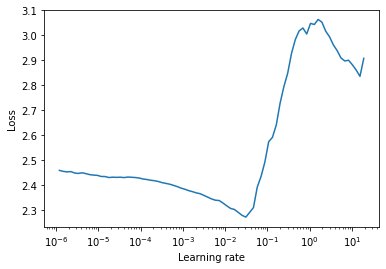

In [11]:
# LR finder fast ai approach
from eva4LRFinder import LRFinder
import torch.optim as optim
import torch.nn as nn
L1lambda = 0
L2lambda = 1e-4
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=1e-7, momentum=0.9, nesterov=True, weight_decay=L2lambda)
lr_finder = LRFinder(model, optimizer, criterion, device=model.device)
lr_finder.range_test(train_loader, end_lr=100, num_iter=100)
lr_finder.plot() # to inspect the loss-learning rate graph
lr_finder.reset() # to reset the model and optimizer to their initial state

In [0]:
loss = lr_finder.history['loss']
lr = lr_finder.history['lr']
#lr[loss.index(min(loss))]
optimizer = optim.SGD(model.parameters(), lr=lr[loss.index(min(loss))], momentum=0.9, nesterov=True, weight_decay=L2lambda)

# Training and Testing

Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cooler logs. 

Let's write train and test functions

In [13]:
#from torch.optim.lr_scheduler import StepLR

from torch.optim.lr_scheduler import ReduceLROnPlateau
EPOCHS = 50
#scheduler = StepLR(optimizer, step_size=5, gamma=0.5)
#scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.5, steps_per_epoch=len(train_loader), epochs=EPOCHS)
scheduler = ReduceLROnPlateau(optimizer, min_lr=1e-7, patience = 2)

model.gotrain(optimizer, train_loader, test_loader, EPOCHS, "/content/drive/My Drive", scheduler, False, L1lambda)


Validation loss decreased (100000.000000 --> 1.186040).  Saving model ...
Epoch: 1, Train set: Average loss: 0.0125, Accuracy: 42.96%; Test set: Average loss: 1.1860, Accuracy: 58.86%
Learning Rate = 0.030903



Validation loss decreased (1.186040 --> 0.827356).  Saving model ...
Epoch: 2, Train set: Average loss: 0.0086, Accuracy: 61.22%; Test set: Average loss: 0.8274, Accuracy: 70.95%
Learning Rate = 0.030903



Validation loss decreased (0.827356 --> 0.751641).  Saving model ...
Epoch: 3, Train set: Average loss: 0.0070, Accuracy: 68.59%; Test set: Average loss: 0.7516, Accuracy: 74.16%
Learning Rate = 0.030903



Validation loss decreased (0.751641 --> 0.643493).  Saving model ...
Epoch: 4, Train set: Average loss: 0.0062, Accuracy: 72.45%; Test set: Average loss: 0.6435, Accuracy: 78.47%
Learning Rate = 0.030903



Epoch: 5, Train set: Average loss: 0.0055, Accuracy: 75.49%; Test set: Average loss: 0.6743, Accuracy: 77.83%
Learning Rate = 0.030903



Validation loss decreased (0.643493 --> 0.582901).  Saving model ...
Epoch: 6, Train set: Average loss: 0.0051, Accuracy: 77.50%; Test set: Average loss: 0.5829, Accuracy: 81.04%
Learning Rate = 0.030903



Validation loss decreased (0.582901 --> 0.562907).  Saving model ...
Epoch: 7, Train set: Average loss: 0.0046, Accuracy: 79.62%; Test set: Average loss: 0.5629, Accuracy: 80.88%
Learning Rate = 0.030903



Validation loss decreased (0.562907 --> 0.559990).  Saving model ...
Epoch: 8, Train set: Average loss: 0.0043, Accuracy: 80.98%; Test set: Average loss: 0.5600, Accuracy: 81.97%
Learning Rate = 0.030903



Validation loss decreased (0.559990 --> 0.458700).  Saving model ...
Epoch: 9, Train set: Average loss: 0.0041, Accuracy: 81.78%; Test set: Average loss: 0.4587, Accuracy: 84.62%
Learning Rate = 0.030903



Epoch: 10, Train set: Average loss: 0.0038, Accuracy: 83.02%; Test set: Average loss: 0.4922, Accuracy: 83.78%
Learning Rate = 0.030903



Epoch: 11, Train set: Average loss: 0.0037, Accuracy: 83.96%; Test set: Average loss: 0.4714, Accuracy: 84.66%
Learning Rate = 0.030903



Validation loss decreased (0.458700 --> 0.416385).  Saving model ...
Epoch: 12, Train set: Average loss: 0.0035, Accuracy: 84.50%; Test set: Average loss: 0.4164, Accuracy: 85.98%
Learning Rate = 0.030903



Epoch: 13, Train set: Average loss: 0.0033, Accuracy: 85.32%; Test set: Average loss: 0.4341, Accuracy: 85.91%
Learning Rate = 0.030903



Validation loss decreased (0.416385 --> 0.386789).  Saving model ...
Epoch: 14, Train set: Average loss: 0.0031, Accuracy: 86.14%; Test set: Average loss: 0.3868, Accuracy: 86.71%
Learning Rate = 0.030903



Epoch: 15, Train set: Average loss: 0.0030, Accuracy: 86.84%; Test set: Average loss: 0.3953, Accuracy: 86.97%
Learning Rate = 0.030903



Epoch: 16, Train set: Average loss: 0.0028, Accuracy: 87.36%; Test set: Average loss: 0.4407, Accuracy: 86.06%
Learning Rate = 0.030903



Epoch: 17, Train set: Average loss: 0.0027, Accuracy: 87.83%; Test set: Average loss: 0.4191, Accuracy: 86.54%
Learning Rate = 0.030903



Epoch: 18, Train set: Average loss: 0.0026, Accuracy: 88.43%; Test set: Average loss: 0.4748, Accuracy: 85.17%
Learning Rate = 0.030903



Epoch: 19, Train set: Average loss: 0.0025, Accuracy: 88.74%; Test set: Average loss: 0.4323, Accuracy: 85.96%
Learning Rate = 0.030903



Validation loss decreased (0.386789 --> 0.377736).  Saving model ...
Epoch: 20, Train set: Average loss: 0.0024, Accuracy: 89.18%; Test set: Average loss: 0.3777, Accuracy: 87.75%
Learning Rate = 0.030903



Validation loss decreased (0.377736 --> 0.360620).  Saving model ...
Epoch: 21, Train set: Average loss: 0.0023, Accuracy: 89.55%; Test set: Average loss: 0.3606, Accuracy: 88.89%
Learning Rate = 0.030903



Epoch: 22, Train set: Average loss: 0.0022, Accuracy: 89.98%; Test set: Average loss: 0.4340, Accuracy: 86.82%
Learning Rate = 0.030903



Epoch: 23, Train set: Average loss: 0.0021, Accuracy: 90.35%; Test set: Average loss: 0.3735, Accuracy: 88.38%
Learning Rate = 0.030903



Validation loss decreased (0.360620 --> 0.360335).  Saving model ...
Epoch: 24, Train set: Average loss: 0.0021, Accuracy: 90.73%; Test set: Average loss: 0.3603, Accuracy: 88.52%
Learning Rate = 0.030903



Validation loss decreased (0.360335 --> 0.352348).  Saving model ...
Epoch: 25, Train set: Average loss: 0.0020, Accuracy: 90.93%; Test set: Average loss: 0.3523, Accuracy: 88.98%
Learning Rate = 0.030903



Epoch: 26, Train set: Average loss: 0.0019, Accuracy: 91.32%; Test set: Average loss: 0.3572, Accuracy: 89.05%
Learning Rate = 0.030903



Validation loss decreased (0.352348 --> 0.340265).  Saving model ...
Epoch: 27, Train set: Average loss: 0.0019, Accuracy: 91.57%; Test set: Average loss: 0.3403, Accuracy: 89.34%
Learning Rate = 0.030903



Validation loss decreased (0.340265 --> 0.334451).  Saving model ...
Epoch: 28, Train set: Average loss: 0.0018, Accuracy: 91.79%; Test set: Average loss: 0.3345, Accuracy: 90.01%
Learning Rate = 0.030903



Epoch: 29, Train set: Average loss: 0.0018, Accuracy: 91.91%; Test set: Average loss: 0.3690, Accuracy: 88.40%
Learning Rate = 0.030903



Validation loss decreased (0.334451 --> 0.323872).  Saving model ...
Epoch: 30, Train set: Average loss: 0.0018, Accuracy: 92.26%; Test set: Average loss: 0.3239, Accuracy: 89.68%
Learning Rate = 0.030903



Validation loss decreased (0.323872 --> 0.303300).  Saving model ...
Epoch: 31, Train set: Average loss: 0.0017, Accuracy: 92.37%; Test set: Average loss: 0.3033, Accuracy: 90.35%
Learning Rate = 0.030903



Epoch: 32, Train set: Average loss: 0.0017, Accuracy: 92.65%; Test set: Average loss: 0.3360, Accuracy: 90.06%
Learning Rate = 0.030903



Epoch: 33, Train set: Average loss: 0.0016, Accuracy: 92.77%; Test set: Average loss: 0.3657, Accuracy: 89.17%
Learning Rate = 0.030903



Epoch: 34, Train set: Average loss: 0.0016, Accuracy: 93.04%; Test set: Average loss: 0.3103, Accuracy: 90.47%
Learning Rate = 0.030903



Validation loss decreased (0.303300 --> 0.299567).  Saving model ...
Epoch: 35, Train set: Average loss: 0.0015, Accuracy: 93.14%; Test set: Average loss: 0.2996, Accuracy: 90.96%
Learning Rate = 0.030903



Epoch: 36, Train set: Average loss: 0.0015, Accuracy: 93.23%; Test set: Average loss: 0.3316, Accuracy: 89.78%
Learning Rate = 0.030903



Epoch: 37, Train set: Average loss: 0.0015, Accuracy: 93.48%; Test set: Average loss: 0.3180, Accuracy: 90.06%
Learning Rate = 0.030903



Epoch: 38, Train set: Average loss: 0.0014, Accuracy: 93.56%; Test set: Average loss: 0.3160, Accuracy: 90.42%
Learning Rate = 0.030903



Epoch: 39, Train set: Average loss: 0.0014, Accuracy: 93.70%; Test set: Average loss: 0.3303, Accuracy: 90.03%
Learning Rate = 0.030903



Epoch: 40, Train set: Average loss: 0.0014, Accuracy: 93.91%; Test set: Average loss: 0.3180, Accuracy: 90.29%
Learning Rate = 0.030903



Epoch: 41, Train set: Average loss: 0.0013, Accuracy: 94.22%; Test set: Average loss: 0.3392, Accuracy: 90.13%
Learning Rate = 0.030903



Epoch: 42, Train set: Average loss: 0.0013, Accuracy: 94.21%; Test set: Average loss: 0.3073, Accuracy: 90.79%
Learning Rate = 0.030903



Epoch: 43, Train set: Average loss: 0.0013, Accuracy: 94.20%; Test set: Average loss: 0.3087, Accuracy: 91.14%
Learning Rate = 0.030903



Epoch: 44, Train set: Average loss: 0.0013, Accuracy: 94.29%; Test set: Average loss: 0.3311, Accuracy: 90.13%
Learning Rate = 0.030903



Epoch: 45, Train set: Average loss: 0.0013, Accuracy: 94.31%; Test set: Average loss: 0.3285, Accuracy: 90.30%
Learning Rate = 0.030903



Epoch: 46, Train set: Average loss: 0.0012, Accuracy: 94.71%; Test set: Average loss: 0.3238, Accuracy: 90.49%
Learning Rate = 0.030903



Epoch: 47, Train set: Average loss: 0.0012, Accuracy: 94.81%; Test set: Average loss: 0.3139, Accuracy: 90.91%
Learning Rate = 0.030903



Epoch: 48, Train set: Average loss: 0.0012, Accuracy: 94.83%; Test set: Average loss: 0.3430, Accuracy: 89.98%
Learning Rate = 0.030903



Validation loss decreased (0.299567 --> 0.291046).  Saving model ...
Epoch: 49, Train set: Average loss: 0.0012, Accuracy: 94.80%; Test set: Average loss: 0.2910, Accuracy: 91.45%
Learning Rate = 0.030903



Epoch: 50, Train set: Average loss: 0.0012, Accuracy: 94.78%; Test set: Average loss: 0.3026, Accuracy: 91.12%
Learning Rate = 0.030903



In [31]:
print(max(model.stats().train_acc))
print(max(model.stats().test_acc))

0.94834
0.9145


# Accuracy curves

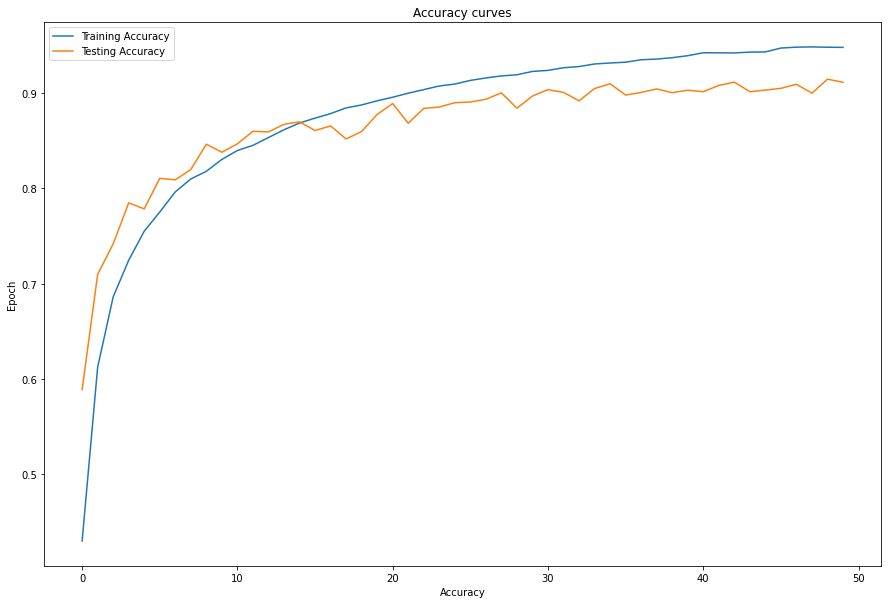

In [24]:
plt.figure(figsize=(15, 10))
ax = plt.subplot(111)
ax.plot(model.stats().train_acc)
ax.plot(model.stats().test_acc)

ax.set(title="Accuracy curves", xlabel="Accuracy", ylabel="Epoch")
ax.legend(['Training Accuracy', 'Testing Accuracy'], loc='best')
plt.savefig("TrainTestAccuracy.png")
plt.show()

In [25]:
len(model.stats().get_misclassified_images())

25

# Misclassified images

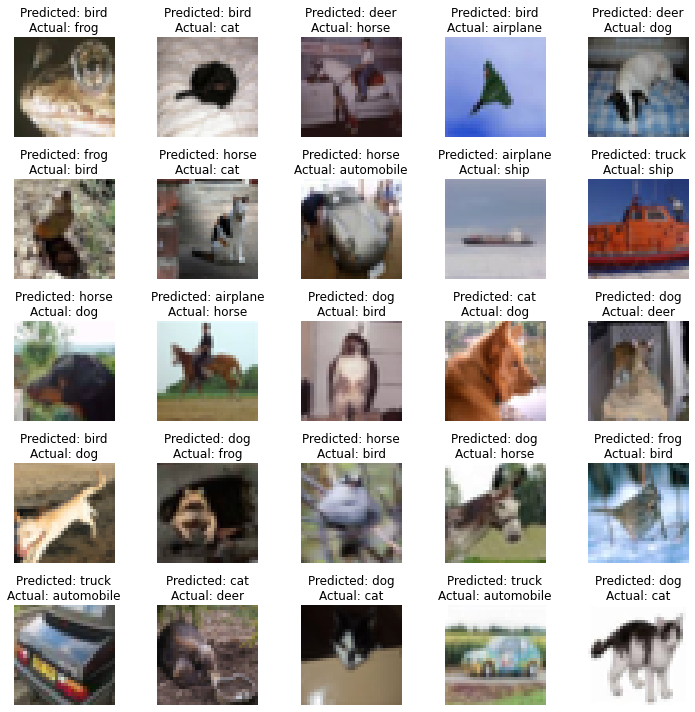

In [26]:

import plots

plots.plot_images(model.stats().get_misclassified_images(), class_names, "misclassified_imgs.png", mean=list(channel_means), std=list(channel_stdevs))


# GRAD CAM

In [0]:
mimages = model.stats().get_misclassified_images()
images = []
target_classes = []
pred_classes = []
for i in mimages:
  images.append(i["img"])
  target_classes.append(int(i['target']))
  pred_classes.append(int(i['pred']))

In [28]:
print(target_classes)
print(pred_classes)

[6, 3, 7, 0, 5, 2, 3, 1, 8, 8, 5, 7, 2, 5, 4, 5, 6, 2, 7, 2, 1, 4, 3, 1, 3]
[2, 2, 4, 2, 4, 6, 7, 7, 0, 9, 7, 0, 5, 3, 5, 2, 5, 7, 5, 6, 9, 3, 5, 9, 5]


In [21]:
model.load_state_dict(torch.load(f"/content/drive/My Drive/{model.name}.pt"))

<All keys matched successfully>

torch.Size([10, 10])
Generating Grad-CAM @layer1
Generating Grad-CAM @layer2
Generating Grad-CAM @layer3
Generating Grad-CAM @layer4


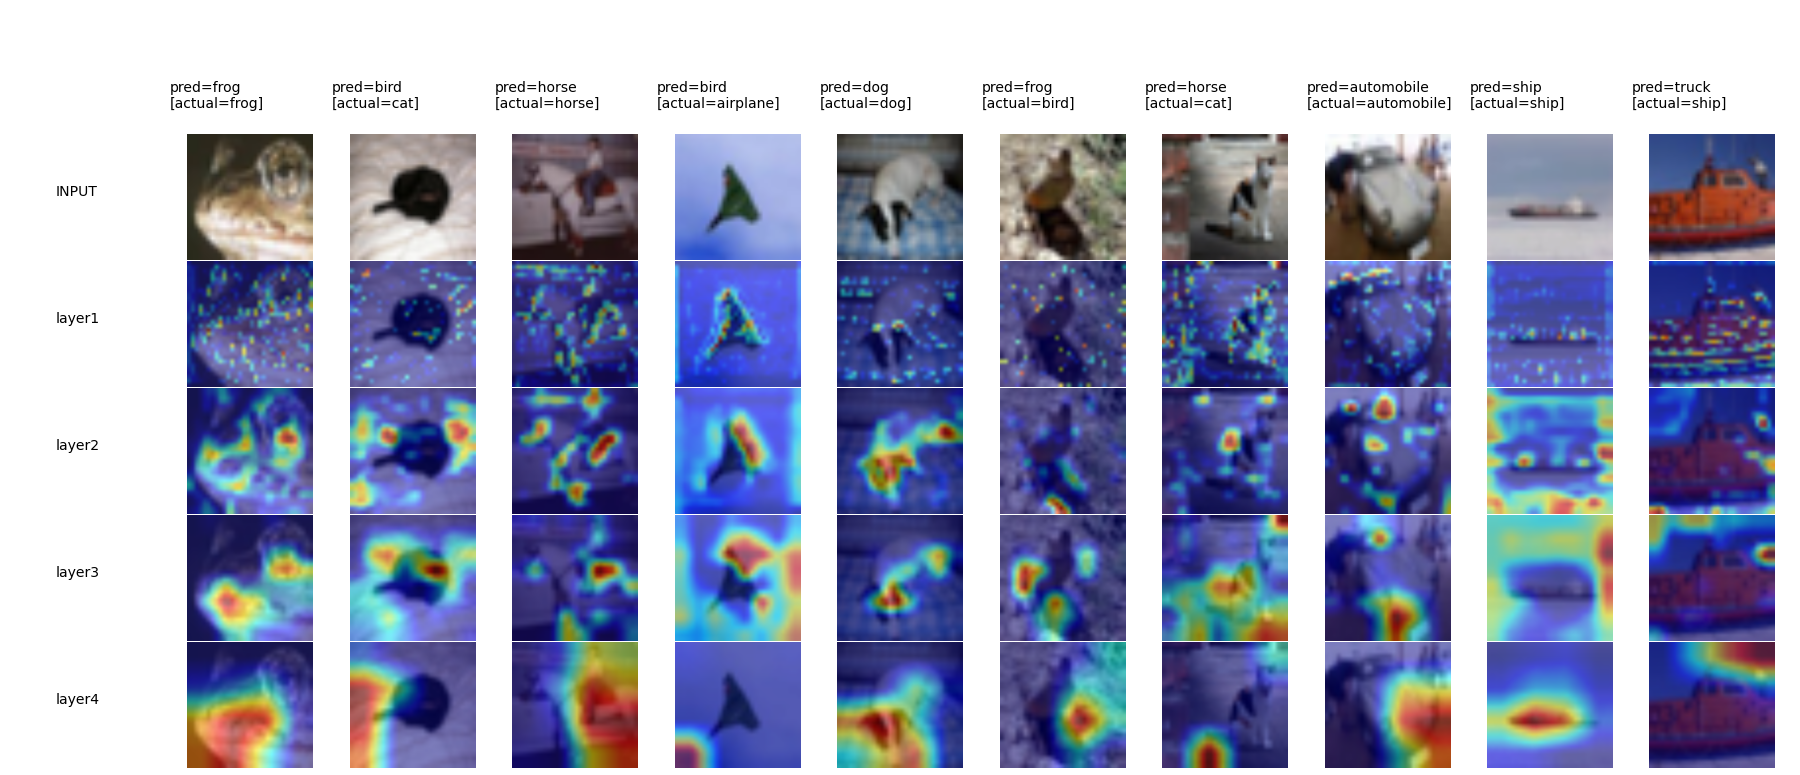

torch.Size([10, 10])
Generating Grad-CAM @layer1
Generating Grad-CAM @layer2
Generating Grad-CAM @layer3
Generating Grad-CAM @layer4


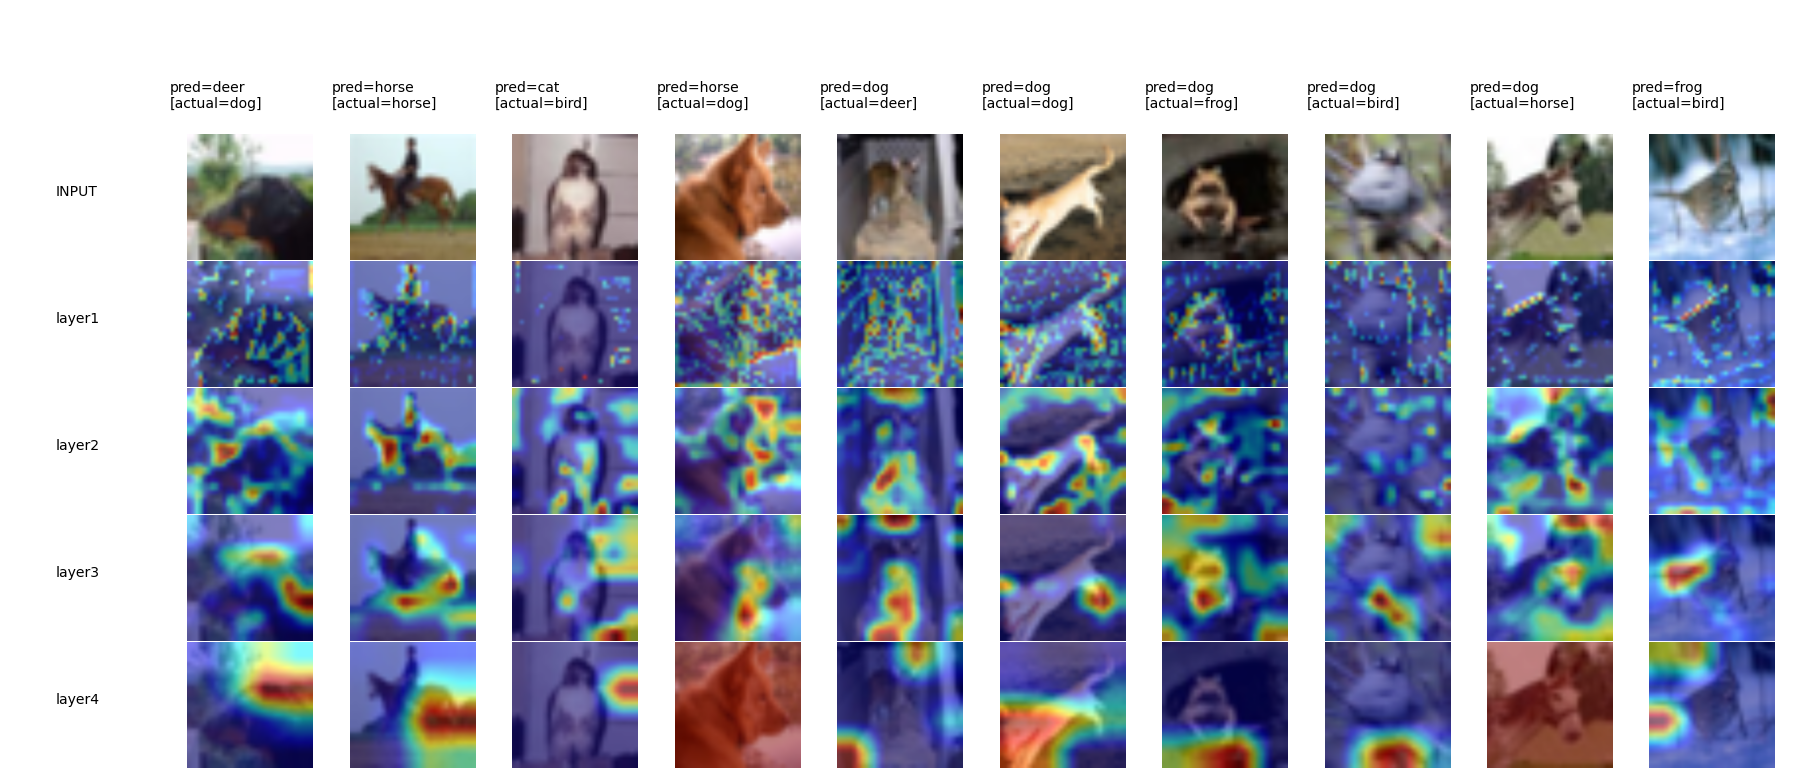

torch.Size([5, 10])
Generating Grad-CAM @layer1
Generating Grad-CAM @layer2
Generating Grad-CAM @layer3
Generating Grad-CAM @layer4


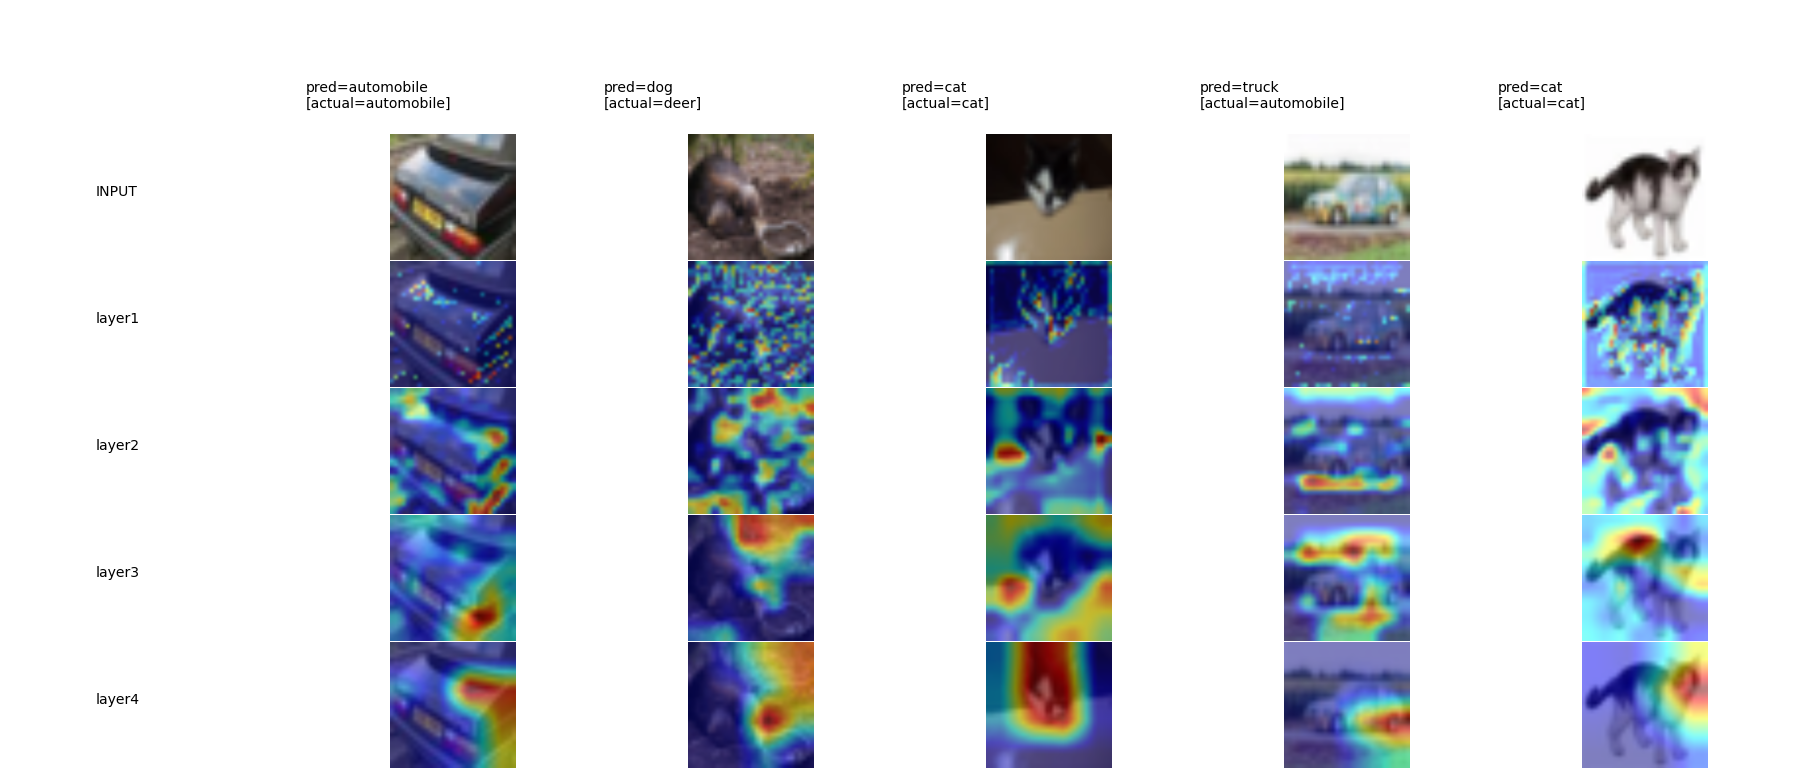

In [29]:
from eva4gradcam import GRADCAM, PLOT
target_layers = ["layer1", "layer2", "layer3", "layer4"]
#Gradcam plot for first 10 misclassified images
gradcam_output, probs, predicted_classes = GRADCAM(images[:10], target_classes[:10], model, target_layers)
PLOT(gradcam_output, images[:10], target_classes[:10], target_layers, class_names, (3, 32, 32), predicted_classes, unnormalize)
#Gradcam plot for 11-20 misclassified images
gradcam_output, probs, predicted_classes = GRADCAM(images[10:20], target_classes[10:20], model, target_layers)
PLOT(gradcam_output, images[10:20], target_classes[10:20], target_layers, class_names, (3, 32, 32), predicted_classes, unnormalize)
#Gradcam plot for 21-25 misclassified images
gradcam_output, probs, predicted_classes = GRADCAM(images[20:], target_classes[20:], model, target_layers)
PLOT(gradcam_output, images[20:], target_classes[20:], target_layers, class_names, (3, 32, 32), predicted_classes, unnormalize)

In [23]:
model.stats().epochs

50